# Here we train a GAN to add details to the upsampled images by cubic interpolation

In [1]:
from probadata import *
import time

from IPython.display import clear_output

In [2]:
ds = ProbaVDataset("GeneratedData/")

In [31]:
import os
from glob import glob

import skimage
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from supreshelper import *

from typing import List

PATCH_SIZE = 32
LR_HR_RATIO = 3
HR_MAX = 17500


class Scene() :
    """Data holder for scene images paths containing list of paths and paths to all
    relevant images in the scene
    """
    
    def __init__(self, qms: List[str], lrs: List[str], sm: str, uplr:str, hr: str=None):
        self.qms = qms
        self.lrs = lrs
        self. sm = sm
        self.hr = hr
        self.uplr = uplr

class ProbaVDataset():
    """Management of the proba-v-super-resolution challenge's data.
    1) Check if the provided data matches the hypothesis
    2) Load images/patches
    3) ...
    
    Attributes:
        data_dir: string path to the Data folder (containing the train and test folders)
    """
    
    def __init__(self, data_dir: str):
        self.train_samples = glob(data_dir +  "train/*/*") 
        self.test_samples = glob(data_dir + "test/*/*")
        
        self._check_dataset()
        
        # We store current pivot to vizualize, a bit hacky for now
        self.pivot = None
        
    
    def _check_dataset(self):
        """Check that the downloaded data respects the following
            - always with at least 9 QM/LR
            - Same number of LR and QM
            - SM/HR exists
        """
        for scene_path in self.train_samples + self.test_samples:
            scene = self.get_scene_content(scene_path)
            assert (len(scene.qms) >= 9), "Less than 9 images at scene" + scene_path
            assert (os.path.isfile(scene.sm)), "Missing SM image at scene " + scene_path
            
            if scene_path.split("/")[1] == "train":
                assert (len(scene.lrs) == len(scene.qms) + 1), "Number of QMS and LRS + 1 images are not identical at scene " + scene_path + ": " + str(len(scene.lrs) + 1) + " / " + str(len(scene.qms))
                assert (os.path.isfile(scene.hr)), "Missing HR image at scene " + scene_path
            else:
                assert (len(scene.lrs) == len(scene.qms)), "Number of QMS and LRS images are not identical at scene " + scene_path + ": " + str(len(scene.lrs) + 1) + " / " + str(len(scene.qms))
                assert (os.path.isfile(scene.uplr)), "Missing SM image at scene " + scene_path
                
    def get_scene_content(self, scene_path: str):
        """Finds the file for a given scene (folder) in the dataset

            Args:
                scene_path: The path to scene's folder

            Returns
                a Scene object (see Scene class)
        """
        qms = glob(scene_path + "/QM*.png")
        lrs = glob(scene_path + "/LR*.png")
        sm = scene_path + "/SM.png"
        hr = scene_path + "/HR.png"
        up_lr = scene_path + "/up_LR.png"
        
        return Scene(qms, lrs, sm, up_lr, hr)
    
    def load_image(self, img_path, is_quality_map=False):
        image = tf.image.decode_png(tf.io.read_file(img_path), dtype=tf.uint16)
        input_image = tf.cast(image, tf.float32)
        if not is_quality_map:
            return input_image / HR_MAX
        else:
            return input_image
        
    """
    Patches Block
    """
    # Jitter is basically 40 - 32
    def load_qms_lrs_patches(self, scene: Scene, pivot: tf.Tensor, jitter: int=8):
        j_d = (int)((PATCH_SIZE + 8) / 2)
        h,w = pivot
        
        slices = [slice(h - j_d, h + j_d), slice(w - j_d, w + j_d), 0]
        qm_tensors = [self.load_image(path, True)[slices] for path in scene.qms]
        lr_tensors = [self.load_image(path)[slices] for path in scene.lrs]

        # Contains list of [qm, lr] tensors pairs 
        patches_stack = [tf.stack([qm, lr], axis=0) for qm, lr in zip(qm_tensors, lr_tensors)]
        return patches_stack
    
    def load_hr_sm(self, scene: Scene):
        hr = self.load_image(scene.hr)
        sm = self.load_image(scene.sm, True)
        return sm, hr
    
    def visuzalize(self, scene: Scene):
        """ Shows an example of input output 
        """
        # Get scene tensors
        stack_cropped, label = self.get_random_patch_stack_and_label(scene)
        
        fig = plt.figure(figsize=(25,25))
        i = 1
        for s_c in stack_cropped:
            ax = plt.subplot(15,4,i)
            ax.axis('off');
            plt.imshow(s_c[0], cmap="copper", vmin=0, vmax=255)
            ax = plt.subplot(15,4,i+1)
            ax.axis('off');
            plt.imshow(s_c[1])
            i += 2
            
        fig = plt.figure(figsize=(10,10))
        ax = plt.subplot(1,2,1)
        ax.axis('off');
        plt.imshow(label[0], cmap="copper", vmin=0, vmax=255)
        ax = plt.subplot(1,2,2)
        ax.axis('off');
        plt.imshow(label[1])
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,2,1)
        ax.axis('off');
        ax.add_patch(matplotlib.patches.Rectangle((self.pivot[1]*3 - 48, self.pivot[0]*3 - 48), 96, 96, color="red", alpha=0.3))
        plt.imshow(self.load_image(scene.sm, True)[:,:,0], cmap="copper", vmin=0, vmax=255)
        
        ax = fig.add_subplot(1,2,2)
        ax.axis('off');
        plt.imshow(self.load_image(scene.hr)[:,:,0])
        ax.add_patch(matplotlib.patches.Rectangle((self.pivot[1]*3 - 48, self.pivot[0]*3 - 48), 96, 96, color="red", alpha=0.3))
        plt.show()
    
    def get_random_patch_stack_and_label(self, scene: Scene):
        pivot = ds.get_pivot().numpy()
        self.pivot = pivot
        
        jitter = 8
        patches_stack = self.load_qms_lrs_patches(scene, pivot, jitter)
        # Get Random crop from 40 (depends on jitter) by 40 patch
        stack_cropped = [tf.image.random_crop(patch, size=[2, PATCH_SIZE, PATCH_SIZE]) for patch in patches_stack]
        
        # Get label at pivot point
        sm, hr = self.load_hr_sm(scene)
        j_d = (int)(PATCH_SIZE * LR_HR_RATIO / 2)
        h,w = pivot * 3
        
        slices = [slice(h - j_d, h + j_d), slice(w - j_d, w + j_d), 0]
        label = tf.stack([sm[slices], hr[slices]], axis=0)
        return stack_cropped, label
    
    def get_pivot(self, grid_size:int =128, border_size: int=40):
        return tf.random.uniform([2], border_size, grid_size-border_size, dtype=tf.dtypes.int32)

    """
    Singe Image Block
    """
    
    @tf.function
    def load_train_image(self, filepath, augment=True):
        lr_hr_sm = self.load_image(filepath)
        w = tf.shape(lr_hr_sm)[1]
        w = w // 3
        lr = lr_hr_sm[:, :w, :]
        hr = lr_hr_sm[:, w:2*w, :]
        sm = lr_hr_sm[:, 2*w:3*w, :]
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)
        sm = tf.cast(hr, tf.float32)
        
        if augment:
            return self.random_jitter(lr, hr, sm)
        else:
            return lr, hr, sm
    
    def resize(self, image, height, width):
        return tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    def random_crop(self, lr, hr, sm):
        stacked_image = tf.stack([lr, hr, sm], axis=0)
        cropped_image = tf.image.random_crop(stacked_image, size=[3, 384, 384, 1])
        return cropped_image[0], cropped_image[1], cropped_image[2]
        
    @tf.function()
    def random_jitter(self, lr, hr, sm):
        lr, hr, sm = self.resize(lr, 429, 429), self.resize(hr, 429, 429), self.resize(sm, 429, 429)
        lr, hr, sm = self.random_crop(lr, hr, sm)

        if tf.random.uniform(()) >= 0.5:
            lr = tf.image.flip_left_right(lr)
            hr = tf.image.flip_left_right(hr)
            sm = tf.image.flip_left_right(sm)
            
        if tf.random.uniform(()) >= 0.5:
            lr = tf.image.flip_up_down(lr)
            hr = tf.image.flip_up_down(hr)
            sm = tf.image.flip_up_down(sm)

        return lr, hr, sm
    
    def load_test_image(self, filepath):
        return self.load_image(filepath)
        

In [32]:
data_dir = "DataGenerated/"
ds = ProbaVDataset("DataGenerated/")

In [33]:
BUFFER_SIZE = 400
batch_size = 2

train_dataset = tf.data.Dataset.list_files(data_dir +  "train/*/*/LR_HR_SM.png")
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(ds.load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)

In [34]:
test_dataset = tf.data.Dataset.list_files(data_dir +  "test/*/*/up_LR.png")
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(ds.load_test_image)
test_dataset = test_dataset.batch(1)

In [35]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Activation, Flatten, Dense, Input

class SuperResolutionGan():
    
    def __init__(self):
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        inputs = Input(shape=[384,384,1])
        gen_out = self.generator(inputs)
        model_out = self.discriminator(gen_out)

        self.srg = tf.keras.Model(inputs, [gen_out, model_out])
        
    def build_discriminator(self):
        discriminator_input = tf.keras.layers.Input(shape=[384,384,1])
        
        model = Conv2D(32, 3, strides=1, padding='same')(discriminator_input)
        model = LeakyReLU(alpha = 0.2)(model)
        model = self.discriminator_block(model, 32, 3, 2)
        model = self.discriminator_block(model, 64, 3, 1)
        model = self.discriminator_block(model, 64, 3, 2)
        model = self.discriminator_block(model, 128, 3, 1)
        model = self.discriminator_block(model, 128, 3, 2)
        model = self.discriminator_block(model, 256, 3, 1)
        model = self.discriminator_block(model, 256, 3, 2)
        # need more depth?
        
        model = Flatten()(model)
        model = Dense(512)(model)
        model = LeakyReLU(alpha = 0.2)(model)
        
        # One final output value if the image was "generated" aka upsampled or not
        model = Dense(1)(model)
        model = Activation('sigmoid')(model)
        
        return tf.keras.Model(inputs = discriminator_input, outputs = model)
        
    def build_generator(self):
            generator_input = tf.keras.layers.Input(shape=[384,384,1])

            model = Conv2D(64, 9, strides=1, padding='same')(generator_input)
            for i in range(10):
                model = self.residual_block_gen(model, 3, 64, 1)

            model = Conv2D(32, 3, strides=1, padding='same')(model)
            model = LeakyReLU(alpha = 0.25)(model)
            #model = BatchNormalization()(model) # momentum = 0.5?
            model = Conv2D(16, 3, strides=1, padding='same')(model)
            model = LeakyReLU(alpha = 0.25)(model)
            model = Conv2D(1, 9, strides=1, padding='same')(model)
            model = Activation('tanh')(model)

            return tf.keras.Model(inputs=generator_input, outputs=model)
        

    def residual_block_gen(self, model, kernel_size, filters, strides):
        # for skip connection since this is a residual block
        previous = model
        
        initializer = tf.random_normal_initializer(0., 0.02) # TODO
        
        model = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer=initializer)(model)
        model = BatchNormalization()(model)
        model = LeakyReLU()(model)
        model = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer=initializer)(model)
        model = BatchNormalization()(model)
        
        return tf.keras.layers.Add()([previous, model])
    
    
    def discriminator_block(self, model, filters, kernel, strides):
        initializer = tf.random_normal_initializer(0., 0.02)
        
        model = Conv2D(filters, kernel, strides = strides, padding = "same", kernel_initializer=initializer)(model)
        model = BatchNormalization()(model)
        model = LeakyReLU(alpha = 0.2)(model)

        return model

In [36]:
srg = SuperResolutionGan()

tf.Tensor([[0.5000005]], shape=(1, 1), dtype=float32)


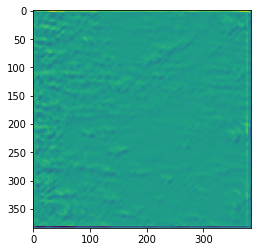

In [9]:
test_output = srg.srg(ds.load_train_image("DataGenerated/train/RED/imgset0478/LR_HR_SM.png")[0][tf.newaxis,...], training=False)
plt.imshow(test_output[0][0][:,:,0])
print(test_output[1])

In [ ]:
def maskedScaledMSE(hr, sm, sr):
    pass
    #TODO

In [37]:
from tensorflow.keras.optimizers import Adam
binary_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

In [38]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = binary_loss(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = binary_loss(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [39]:
def generator_loss(disc_output, gen_output, hr):
    # we try to trick the discriminator to predict our generated image to be considered as valid ([1])
    gan_loss = binary_loss(tf.ones_like(disc_output), disc_output)
    
    # We also want the image to look as similar as possible to the HR images
    # TODO use maskedScaledMSE or MAE
    l1_loss = tf.reduce_mean(tf.abs(hr - gen_output))
    #  [32,384,384,1], [32,1]
    
    # Lambda controls how much we value each loss
    return gan_loss + (LAMBDA * l1_loss)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoints

In [41]:
checkpoint_dir = './TrainingCheckpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=srg.generator,
                                 discriminator=srg.discriminator)

In [42]:
EPOCHS = 2500

In [43]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Get generator output
        gen_output = srg.generator(lr, training=True)
        
        # Get discriminator output for the real image and the super resolved image
        disc_real_output = srg.discriminator(hr, training=True)
        disc_generated_output = srg.discriminator(gen_output, training=True)
        
        # Discriminator is trained to map real image to [1] and generated image to [0] 
        # moved un functions
        #valid = tf.ones(batch_size) # - tf.random.uniform([batch_size]) * 0.2
        #fake = tf.zeros(batch_size) # + tf.random.uniform([batch_size]) * 0.2
        
        # Compute losses for each network using above functions
        gen_loss = generator_loss(disc_generated_output, gen_output, hr)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        # We compute gradient for each part
        generator_gradients = gen_tape.gradient(gen_loss, srg.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, srg.discriminator.trainable_variables)

        # We apply the gradient to the variables, tf2.0 way
        generator_optimizer.apply_gradients(zip(generator_gradients, srg.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, srg.discriminator.trainable_variables))

    


In [44]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [51]:
def show_test_pred(generator, up_LR):
    predicted = generator.predict(up_LR)
    plt.figure(figsize=(15,15))
    
    display_list = [up_LR[0], predicted[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i][:,:,0])
        plt.axis('off')
    plt.show()
    

In [46]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for lr, hr, sm in dataset:
            train_step(lr, hr)

        #clear_output(wait=True)
        for up_LR in test_dataset.take(1):
            show_test_pred(srg.generator, up_LR)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [47]:
train(train_dataset, 5)

TypeError: predict() got an unexpected keyword argument 'training'

In [58]:
for lr, hr, sm in train_dataset:
    lr = lr
    hr = hr
    break